In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import os
import shutil
from sklearn.model_selection import train_test_split

2024-12-02 18:41:52.587865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733186512.606697    1093 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733186512.612174    1093 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 18:41:52.631605: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set Image directories
dataset_dir = '../dataset/images'
train_dir = '../dataset/train'
validation_dir = '../dataset/val'
test_dir = '../dataset/test'

In [3]:
# Data generator functions (creates our dataset)
def create_datagen(preprocessing_function =""):
    return ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        rescale=1./255  # Normalize pixel values
    )
def create_generator(datagen, directory, shuffle):
    return datagen.flow_from_directory(
        directory,
        target_size=(300,300),
        batch_size=16,
        class_mode='categorical',
        shuffle=shuffle,
    )

In [4]:
# Create data generators (datasets for validation, testing, and training)
datagen_cnn = create_datagen(tf.keras.applications.vgg16.preprocess_input)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator_cnn = create_generator(datagen_cnn, train_dir, True)
val_generator = create_generator(val_datagen, validation_dir, True)
test_generator = create_generator(test_datagen, test_dir, False)

Found 14357 images belonging to 120 classes.
Found 3082 images belonging to 120 classes.
Found 3141 images belonging to 120 classes.


In [5]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))

# 1st Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# 2nd Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))

# 3rd Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu'))

# 4th Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
model.add(Flatten())

# Fully Connected (Dense) Layer
model.add(Dense(512, activation='relu'))

# Output Layer (categorical classification (120 predicatable outputs))
model.add(Dense(120, activation='softmax'))


/home/astro/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733186523.056167    1093 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5919 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 33, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,004,920 (129.72 MB)

 Trainable params: 34,004,920 (129.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Model Training
history = model.fit(train_generator_cnn, validation_data=val_generator, epochs=10)

/home/astro/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1733186534.637738   43351 service.cc:148] XLA service 0x7f04200103d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733186534.637824   43351 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-12-02 18:42:14.668266: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733186534.864767   43351 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-02 18:42:15.491350: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,32,298,298]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,300,300]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config"

  3/898 ━━━━━━━━━━━━━━━━━━━━ 56s 63ms/step - accuracy: 0.0000e+00 - loss: 5.3941

I0000 00:00:1733186540.497021   43351 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


874/898 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.0098 - loss: 4.8036

2024-12-02 18:44:05.103480: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[5,32,298,298]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,3,300,300]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-02 18:44:05.213477: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[5,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,32,149,149]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.0098 - loss: 4.8032

2024-12-02 18:44:12.426022: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,32,298,298]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,300,300]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-02 18:44:12.545525: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,149,149]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

898/898 ━━━━━━━━━━━━━━━━━━━━ 143s 151ms/step - accuracy: 0.0098 - loss: 4.8032 - val_accuracy: 0.0123 - val_loss: 4.7808
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 129s 144ms/step - accuracy: 0.0100 - loss: 4.7820 - val_accuracy: 0.0123 - val_loss: 4.7793
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 127s 141ms/step - accuracy: 0.0119 - loss: 4.7814 - val_accuracy: 0.0123 - val_loss: 4.7789
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 126s 141ms/step - accuracy: 0.0109 - loss: 4.7811 - val_accuracy: 0.0123 - val_loss: 4.7792
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 126s 140ms/step - accuracy: 0.0113 - loss: 4.7794 - val_accuracy: 0.0123 - val_loss: 4.7789
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 121s 135ms/step - accuracy: 0.0118 - loss: 4.7809 - val_accuracy: 0.0123 - val_loss: 4.7787
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 121s 135ms/step - accuracy: 0.0125 - loss: 4.7811 - val_accuracy: 0.0123 - val_loss: 4.7787
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 124s 138ms/step - accuracy: 0.0126 - loss: 4.78

3141/3141 ━━━━━━━━━━━━━━━━━━━━ 102s 25ms/step - accuracy: 0.0143 - loss: 4.7771  
Test Loss: 4.7791523933410645
Test Accuracy: 0.012098058126866817


2024-12-02 19:15:51.622721: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-02 19:15:51.622767: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14436069193358471289
2024-12-02 19:15:51.622789: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1461537647547558477
/home/astro/miniconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3141/3141 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step   
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        23
           1       1.00      0.00      0.00        28
           2       0.01      1.00      0.02        38
           3       1.00      0.00      0.00        23
           4       1.00      0.00      0.00        33
           5       1.00      0.00      0.00        29
           6       1.00      0.00      0.00        30
           7       1.00      0.00      0.00        26
           8       1.00      0.00      0.00        26
           9       1.00      0.00      0.00        36
          10       1.00      0.00      0.00        27
          11       1.00      0.00      0.00        30
          12       1.00      0.00      0.00        29
          13       1.00      0.00      0.00        26
          14       1.00      0.00      0.00        24
          15       1.00      0.00      0.00        23
          1

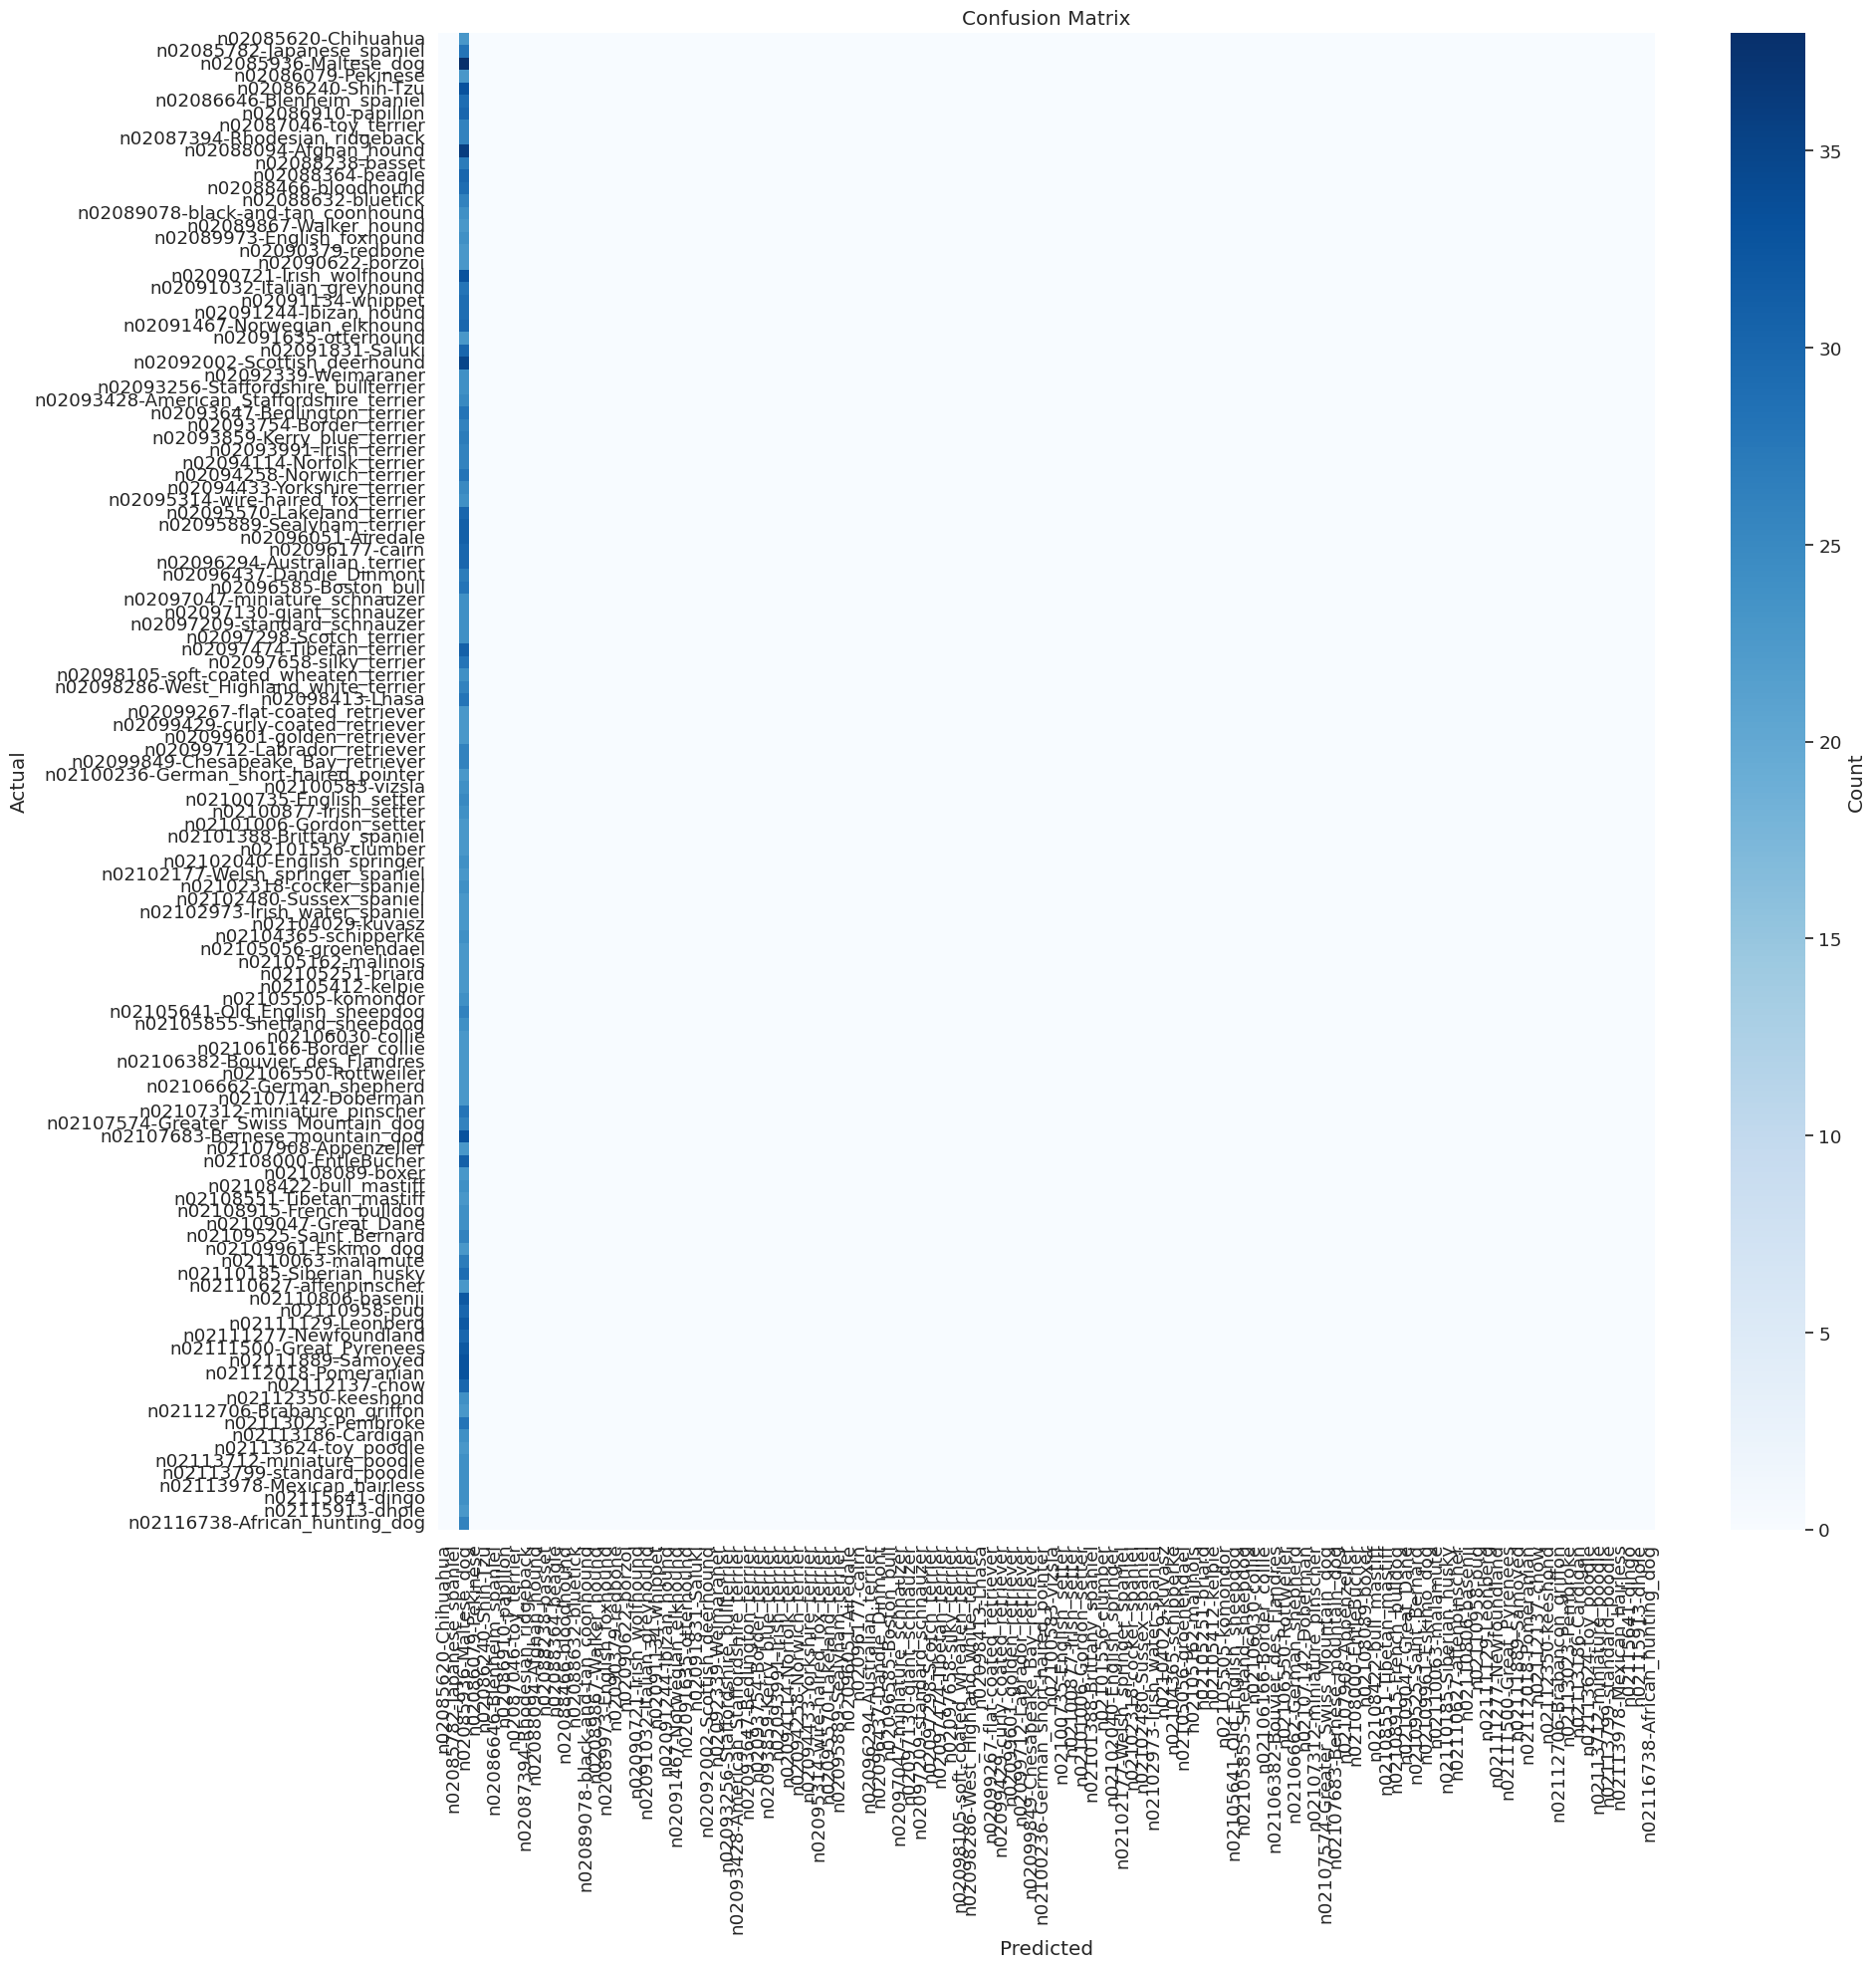

Calculated Accuracy from Confusion Matrix: 1.21%


In [10]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.classes.size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Reset the test generator
test_generator.reset()

# Get the predictions
predictions = model.predict(test_generator, steps=test_generator.classes.size)

# Get true labels
y_true = test_generator.classes

# Convert predicted probabilities to class labels
y_pred = predictions.argmax(axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, zero_division=1))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())
print(class_labels)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print("Confusion Matrix:")
print(conf_matrix_df)

# Set the size of the plot
plt.figure(figsize=(20, 20))

# Set the font scale
sns.set(font_scale=1.2)

# Create heatmap (confusion matrix)
sns.heatmap(conf_matrix_df, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, xticklabels=True, yticklabels=True)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

plt.tight_layout()

plt.show()

# Calculate accuracy from confusion matrix
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Calculated Accuracy from Confusion Matrix: {accuracy * 100:.2f}%")

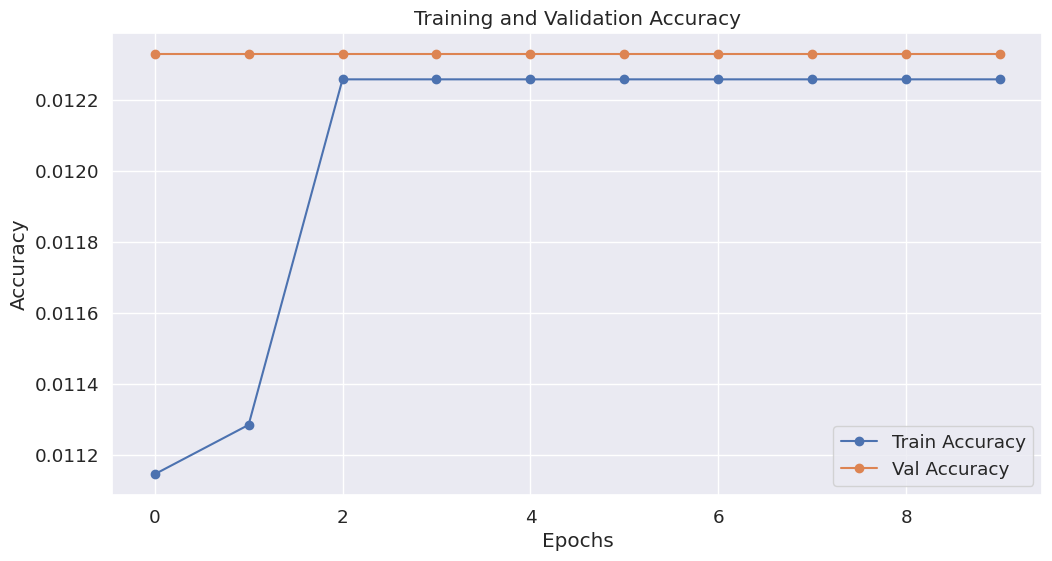

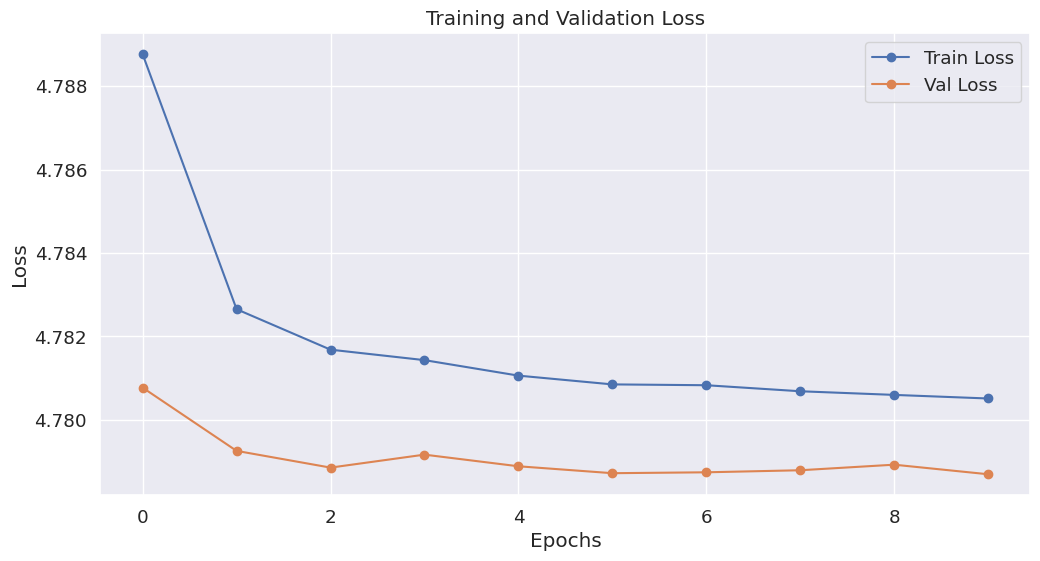

In [11]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()